<a href="https://colab.research.google.com/github/LunaTic-Neon/2025-2-RL/blob/main/25_2_1001_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_5%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib.table import Table

# ======================================================================================
# 파일 1: GridWorld 환경 클래스 및 시각화 함수 (1_GridWrold.txt)
# ======================================================================================
class GridWorld():
    def __init__(
            self,
            height=5, width=5,        # 격자판의 크기
            start_state=(0, 0),       # 시작 상태
            terminal_states=[(4, 4)], # 종료 상태
            transition_reward=0.0,    # 일반적인 상태 전이 보상
            terminal_reward=1.0,      # 종료 상태로 이동하는 행동 수행 때 받는 보상
            outward_reward=0.0,       # 미로 바깥으로 이동하는 행동 수행 때 받는 보상
            warm_hole_states=None     # 웜홀 정의
    ):
        self.__version__ = "0.0.1"
        self.HEIGHT = height
        self.WIDTH = width
        self.STATES = []
        self.num_states = self.WIDTH * self.HEIGHT
        for i in range(self.HEIGHT):
            for j in range(self.WIDTH):
                self.STATES.append((i, j))
        for state in terminal_states:
             self.STATES.remove(state)
        self.current_state = None
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.ACTIONS = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]
        self.ACTION_SYMBOLS = ["↑", "↓", "←", "→"]
        self.NUM_ACTIONS = len(self.ACTIONS)
        self.START_STATE = start_state
        self.TERMINAL_STATES = terminal_states
        self.WARM_HOLE_STATES = warm_hole_states
        self.transition_reward = transition_reward
        self.terminal_reward = terminal_reward
        self.outward_reward = outward_reward

    def reset(self):
        self.current_state = self.START_STATE
        return self.current_state

    def moveto(self, state):
        self.current_state = state

    def is_warm_hole_state(self, state):
        i, j = state
        if self.WARM_HOLE_STATES is not None and len(self.WARM_HOLE_STATES) > 0:
            for warm_hole_info in self.WARM_HOLE_STATES:
                warm_hole_state = warm_hole_info[0]
                if i == warm_hole_state[0] and j == warm_hole_state[1]:
                    return True
        return False

    def get_next_state_warm_hole(self, state):
        i, j = state
        next_state = None
        for warm_hole_info in self.WARM_HOLE_STATES:
            warm_hole_state = warm_hole_info[0]
            warm_hole_prime_state = warm_hole_info[1]
            if i == warm_hole_state[0] and j == warm_hole_state[1]:
                next_state = warm_hole_prime_state
                break
        return next_state

    def get_reward_warm_hole(self, state):
        i, j = state
        reward = None
        for warm_hole_info in self.WARM_HOLE_STATES:
            warm_hole_state = warm_hole_info[0]
            warm_hole_reward = warm_hole_info[2]
            if i == warm_hole_state[0] and j == warm_hole_state[1]:
                reward = warm_hole_reward
                break
        return reward

    def get_next_state(self, state, action):
        i, j = state
        if self.is_warm_hole_state(state):
            next_state = self.get_next_state_warm_hole(state)
            next_i, next_j = next_state[0], next_state[1]
        elif (i, j) in self.TERMINAL_STATES:
            next_i, next_j = i, j
        else:
            if action == self.ACTION_UP:
                next_i, next_j = max(i - 1, 0), j
            elif action == self.ACTION_DOWN:
                next_i, next_j = min(i + 1, self.HEIGHT - 1), j
            elif action == self.ACTION_LEFT:
                next_i, next_j = i, max(j - 1, 0)
            elif action == self.ACTION_RIGHT:
                next_i, next_j = i, min(j + 1, self.WIDTH - 1)
            else:
                raise ValueError()
        return next_i, next_j

    def get_reward(self, state, next_state):
        i, j = state
        next_i, next_j = next_state
        if self.is_warm_hole_state(state):
            reward = self.get_reward_warm_hole(state)
        else:
            if (next_i, next_j) in self.TERMINAL_STATES:
                reward = self.terminal_reward
            elif i == next_i and j == next_j:
                reward = self.outward_reward
            else:
                reward = self.transition_reward
        return reward

    def get_state_action_probability(self, state, action):
        next_i, next_j = self.get_next_state(state, action)
        reward = self.get_reward(state, (next_i, next_j))
        transition_prob = 1.0
        return (next_i, next_j), reward, transition_prob

    def step(self, action):
        next_i, next_j = self.get_next_state(state=self.current_state, action=action)
        reward = self.get_reward(self.current_state, (next_i, next_j))
        self.current_state = (next_i, next_j)
        done = self.current_state in self.TERMINAL_STATES
        return (next_i, next_j), reward, done, None

    def render(self, mode='human'):
        print(self.__str__())

    def get_random_action(self):
        return random.choice(self.ACTIONS)

    def __str__(self):
        gridworld_str = ""
        for i in range(self.HEIGHT):
            gridworld_str += "-------------------------------\n"
            for j in range(self.WIDTH):
                if self.current_state[0] == i and self.current_state[1] == j:
                    gridworld_str += "| {0}  ".format("*")
                elif (i, j) == self.START_STATE:
                    gridworld_str += "| {0}  ".format("S")
                elif (i, j) in self.TERMINAL_STATES:
                    gridworld_str += "| {0}  ".format("G")
                elif self.WARM_HOLE_STATES and (i, j) in [state[0] for state in self.WARM_HOLE_STATES]:
                    gridworld_str += "| {0}  ".format("W")
                else:
                    gridworld_str += "|    "
            gridworld_str += "|\n"
            for j in range(self.WIDTH):
                gridworld_str += "|({0},{1})".format(i, j)
            gridworld_str += "|\n"
        gridworld_str += "-------------------------------\n"
        return gridworld_str

def draw_grid_world_action_values_image(action_values, GRID_HEIGHT, GRID_WIDTH, NUM_ACTIONS, ACTION_SYMBOLS):
    action_str_values = []
    for i in range(GRID_HEIGHT):
        action_str_values.append([])
        for j in range(GRID_WIDTH):
            str_values = []
            for action in range(NUM_ACTIONS):
                str_values.append("{0} ({1}): {2:.2f}".format(
                    ACTION_SYMBOLS[action], action, np.round(action_values[i, j, action], decimals=2)
                ))
            action_str_values[i].append("\n".join(str_values))

    fig, ax = plt.subplots()
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 1])
    nrows, ncols = GRID_HEIGHT, GRID_WIDTH
    width, height = 1.0 / ncols, 1.0 / nrows
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            table.add_cell(i, j, width, height, text=action_str_values[i][j], loc='center', facecolor='white')
    for i in range(len(action_str_values)):
        table.add_cell(i, -1, width, height, text=i+1, loc='right', edgecolor='none', facecolor='none')
        table.add_cell(-1, i, width, height/2, text=i+1, loc='center', edgecolor='none', facecolor='none')
    for key, cell in table.get_celld().items():
         cell.get_text().set_fontsize(10)
    ax.add_table(table)
    plt.show()
    plt.close()

def draw_grid_world_optimal_policy_image(policy, GRID_HEIGHT, GRID_WIDTH, ACTION_SYMBOLS, TERMINAL_STATES=None):
    action_str_values = [[] for _ in range(GRID_HEIGHT)]
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if TERMINAL_STATES and (i, j) in TERMINAL_STATES:
                action_str_values[i].append("")
                continue
            str_values = []
            actions, probs = policy.get((i, j), ([], []))
            for idx, action in enumerate(actions):
                str_values.append("{0} ({1})".format(ACTION_SYMBOLS[action], np.round(probs[idx], decimals=3)))
            action_str_values[i].append("\n".join(str_values))

    fig, ax = plt.subplots()
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 1])
    nrows, ncols = GRID_HEIGHT, GRID_WIDTH
    width, height = 1.0 / ncols, 1.0 / nrows
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            table.add_cell(i, j, width, height, text=action_str_values[i][j], loc='center', facecolor='white')
    for i in range(len(action_str_values)):
        table.add_cell(i, -1, width, height, text=i+1, loc='right', edgecolor='none', facecolor='none')
        table.add_cell(-1, i, width, height/2, text=i+1, loc='center', edgecolor='none', facecolor='none')
    for key, cell in table.get_celld().items():
         cell.get_text().set_fontsize(10)
    ax.add_table(table)
    plt.show()
    plt.close()

def softmax(x):
    B = np.exp(x - np.max(x))
    C = np.sum(B)
    return B/C

# ======================================================================================
# 파일 4: RandomWalk 환경 클래스 및 시각화 함수 (4_randomework.txt)
# ======================================================================================
class RandomWalk():
    def __init__(
            self,
            num_internal_states=5,
            transition_reward=0.0,
            left_terminal_reward=0.0,
            right_terminal_reward=1.0
    ):
        self.__version__ = "0.0.1"
        self.num_internal_states = num_internal_states
        self.num_states = num_internal_states + 2
        self.STATES = [i for i in range(num_internal_states)]
        self.TERMINAL_STATES = ['T1', 'T2']
        self.ACTION_LEFT = 0
        self.ACTION_RIGHT = 1
        self.ACTION_SYMBOLS = ["\u2190", "\u2192"]
        self.ACTIONS = [self.ACTION_LEFT, self.ACTION_RIGHT]
        self.NUM_ACTIONS = len(self.ACTIONS)
        self.START_STATE = self.STATES[int(num_internal_states / 2)]
        self.transition_reward = transition_reward
        self.left_terminal_reward = left_terminal_reward
        self.right_terminal_reward = right_terminal_reward
        self.current_state = None

    def reset(self):
        self.current_state = self.START_STATE
        return self.current_state

    def moveto(self, state):
        self.current_state = state

    def get_next_state(self, state, action):
        if state in self.TERMINAL_STATES:
            next_state = state
        else:
            if action == self.ACTION_LEFT:
                next_state = 'T1' if state == 0 else state - 1
            elif action == self.ACTION_RIGHT:
                next_state = 'T2' if state == self.num_internal_states - 1 else state + 1
            else:
                raise ValueError()
        return next_state

    def get_reward(self, state, next_state):
        if next_state == 'T1': return self.left_terminal_reward
        elif next_state == 'T2': return self.right_terminal_reward
        else: return self.transition_reward

    def get_state_action_probability(self, state, action):
        next_state = self.get_next_state(state, action)
        reward = self.get_reward(state, next_state)
        return next_state, reward, 1.0

    def step(self, action):
        next_state = self.get_next_state(state=self.current_state, action=action)
        reward = self.get_reward(self.current_state, next_state)
        self.current_state = next_state
        done = self.current_state in self.TERMINAL_STATES
        return next_state, reward, done, None

    def render(self, mode='human'):
        print(self.__str__(), end="\n\n")

    def get_random_action(self):
        return random.choice(self.ACTIONS)

    def __str__(self):
        randomwalk_str = f" T1 {' '.join(map(str, range(self.num_internal_states)))} T2\n"
        if self.current_state in self.STATES:
            blank = "    " + "  " * self.current_state
        elif self.current_state == 'T1':
            blank = " "
        elif self.current_state == 'T2':
            blank = "  " + "  " * (self.num_internal_states + 1)
        else:
            raise ValueError()
        randomwalk_str += blank + "*"
        return randomwalk_str

def draw_random_walk_policy_image(policy, env):
    randomwalk_str = f" T1      {'       '.join(map(str, range(env.num_internal_states)))}      T2\n"
    randomwalk_str += "       "
    for state in env.STATES:
        _, prob = policy[state]
        randomwalk_str += f"{env.ACTION_SYMBOLS[env.ACTION_LEFT]}:{np.round(prob[env.ACTION_LEFT], decimals=2):4}  "
    randomwalk_str += "\n       "
    for state in env.STATES:
        _, prob = policy[state]
        randomwalk_str += f"{env.ACTION_SYMBOLS[env.ACTION_RIGHT]}:{np.round(prob[env.ACTION_RIGHT], decimals=2):4}  "
    print(randomwalk_str)

print("공통 설정 셀 실행 완료. 이제 각 실습 셀을 실행할 수 있습니다.")

공통 설정 셀 실행 완료. 이제 각 실습 셀을 실행할 수 있습니다.


<<<<< 첫 방문(First-visit) 몬테카를로 예측 결과 >>>>>
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


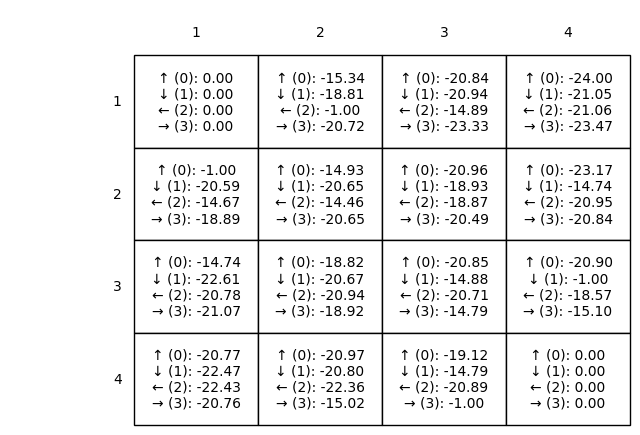


<<<<< 모든 방문(Every-visit) 몬테카를로 예측 결과 >>>>>
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


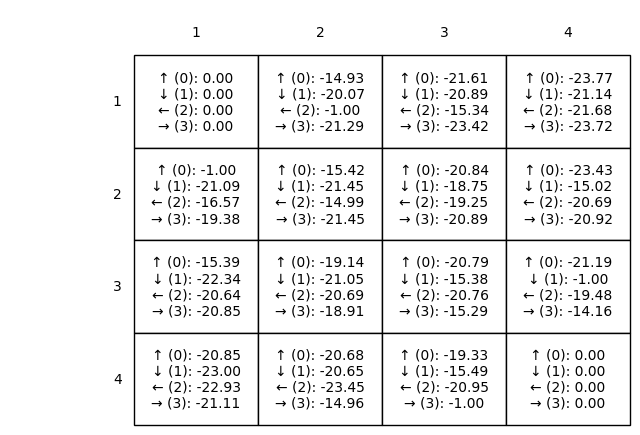

In [2]:
# ======================================================================================
# 파일 2: GridWorld 몬테카를로 예측 (2_GridWrold_MonteCarlo.txt)
# ======================================================================================
GRID_HEIGHT = 4
GRID_WIDTH = 4
TERMINAL_STATES = [(0, 0), (GRID_HEIGHT-1, GRID_WIDTH-1)]

def get_exploring_start_state():
    while True:
        i = random.randrange(GRID_HEIGHT)
        j = random.randrange(GRID_WIDTH)
        if (i, j) not in TERMINAL_STATES:
            break
    return (i, j)

def generate_random_episode_and_state_actions(env):
    episode = []
    visited_state_actions = []
    initial_state = get_exploring_start_state()
    env.moveto(initial_state)
    state = initial_state
    done = False
    while not done:
        action = random.randrange(env.NUM_ACTIONS)
        next_state, reward, done, _ = env.step(action)
        episode.append(((state, action), reward))
        visited_state_actions.append((state, action))
        state = next_state
    return episode, visited_state_actions

def first_visit_mc_prediction(env, gamma, num_iter):
    state_action_values = np.zeros((GRID_HEIGHT, GRID_WIDTH, env.NUM_ACTIONS))
    returns = {((i, j), action): [] for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) for action in env.ACTIONS}

    for i in range(num_iter):
        episode, visited_state_actions = generate_random_episode_and_state_actions(env)
        G = 0
        for idx, ((state, action), reward) in enumerate(reversed(episode)):
            G = gamma * G + reward
            if (state, action) not in visited_state_actions[:len(visited_state_actions) - idx - 1] and state not in TERMINAL_STATES:
                returns[(state, action)].append(G)
                state_action_values[state[0], state[1], action] = np.mean(returns[(state, action)])
        if (i+1) % 1000 == 0:
            print(f"Iteration: {i+1}")
    return state_action_values, returns

def every_visit_mc_prediction(env, gamma, num_iter):
    state_action_values = np.zeros((GRID_HEIGHT, GRID_WIDTH, env.NUM_ACTIONS))
    returns = {((i, j), action): [] for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) for action in env.ACTIONS}

    for i in range(num_iter):
        episode, _ = generate_random_episode_and_state_actions(env)
        G = 0
        for idx, ((state, action), reward) in enumerate(reversed(episode)):
            G = gamma * G + reward
            if state not in TERMINAL_STATES:
                returns[(state, action)].append(G)
                state_action_values[state[0], state[1], action] = np.mean(returns[(state, action)])
        if (i+1) % 1000 == 0:
            print(f"Iteration: {i+1}")
    return state_action_values, returns

def action_value_prediction_main():
    env = GridWorld(
        height=GRID_HEIGHT,
        width=GRID_WIDTH,
        start_state=None,
        terminal_states=TERMINAL_STATES,
        transition_reward=-1.0,
        terminal_reward=-1.0,
        outward_reward=-1.0
    )
    env.reset()

    print("<<<<< 첫 방문(First-visit) 몬테카를로 예측 결과 >>>>>")
    state_action_values, _ = first_visit_mc_prediction(env, 1.0, 10000)
    draw_grid_world_action_values_image(state_action_values, GRID_HEIGHT, GRID_WIDTH, env.NUM_ACTIONS, env.ACTION_SYMBOLS)

    print("\n<<<<< 모든 방문(Every-visit) 몬테카를로 예측 결과 >>>>>")
    state_action_values, _ = every_visit_mc_prediction(env, 1.0, 10000)
    draw_grid_world_action_values_image(state_action_values, GRID_HEIGHT, GRID_WIDTH, env.NUM_ACTIONS, env.ACTION_SYMBOLS)

if __name__ == "__main__":
    action_value_prediction_main()

[[[ MC 제어 반복 시작! ]]]
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 1000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 2000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 3000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 4000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 5000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 6000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 7000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 8000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 9000 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 10000 ***

[[[ MC 제어 반복 종료! ]]]



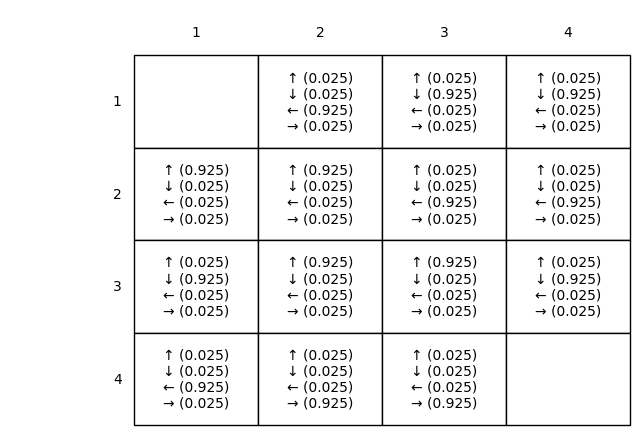

In [3]:
# ======================================================================================
# 파일 3: GridWorld ε-소프트 몬테카를로 제어 (3_e_monte.txt)
# ======================================================================================
EPSILON = 0.1
GRID_HEIGHT = 4
GRID_WIDTH = 4
TERMINAL_STATES = [(0, 0), (GRID_HEIGHT-1, GRID_WIDTH-1)]
DISCOUNT_RATE = 1.0
MAX_EPISODES = 10000 # 원본 100에서 10000으로 수정하여 학습 안정성 향상

def generate_initial_q_value_and_return_gw(env):
    state_action_values = np.zeros((GRID_HEIGHT, GRID_WIDTH, env.NUM_ACTIONS))
    returns = {((i, j), action): [] for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH) for action in env.ACTIONS}
    return state_action_values, returns

def generate_initial_random_policy_gw(env):
    policy = {}
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            policy[(i, j)] = (env.ACTIONS, [0.25] * env.NUM_ACTIONS)
    return policy

def generate_episode_gw(env, policy):
    episode = []
    visited_state_actions = []
    state = env.reset()
    done = False
    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, p=prob)
        next_state, reward, done, _ = env.step(action)
        episode.append(((state, action), reward))
        visited_state_actions.append((state, action))
        state = next_state
    return episode, visited_state_actions

def first_visit_mc_prediction_gw(state_action_values, returns, episode, visited_state_actions):
    G = 0
    for idx, ((state, action), reward) in enumerate(reversed(episode)):
        G = DISCOUNT_RATE * G + reward
        if (state, action) not in visited_state_actions[:len(visited_state_actions) - idx - 1] and state not in TERMINAL_STATES:
            returns[(state, action)].append(G)
            state_action_values[state[0], state[1], action] = np.mean(returns[(state, action)])

def generate_soft_greedy_policy_gw(env, state_action_values, policy):
    new_policy = {}
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            if (i, j) in TERMINAL_STATES:
                new_policy[(i, j)] = (env.ACTIONS, [0.25] * env.NUM_ACTIONS)
            else:
                q_values = state_action_values[i, j, :]
                max_q = np.max(q_values)
                max_prob_actions = [action for action, value in enumerate(q_values) if value == max_q]

                action_probs = []
                for action in env.ACTIONS:
                    prob = EPSILON / env.NUM_ACTIONS
                    if action in max_prob_actions:
                        prob += (1 - EPSILON) / len(max_prob_actions)
                    action_probs.append(prob)
                new_policy[(i, j)] = (env.ACTIONS, action_probs)

    error = sum(np.sum(np.abs(np.array(policy[(i, j)][1]) - np.array(new_policy[(i, j)][1]))) for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH))
    return new_policy, error

def soft_policy_control_main():
    env = GridWorld(
        height=GRID_HEIGHT,
        width=GRID_WIDTH,
        start_state=(0, 1),
        terminal_states=TERMINAL_STATES,
        transition_reward=-1.0,
        terminal_reward=-1.0,
        outward_reward=-1.0
    )

    state_action_values, returns = generate_initial_q_value_and_return_gw(env)
    policy = generate_initial_random_policy_gw(env)

    print("[[[ MC 제어 반복 시작! ]]]")
    for iter_num in range(1, MAX_EPISODES + 1):
        episode, visited_state_actions = generate_episode_gw(env, policy)
        first_visit_mc_prediction_gw(state_action_values, returns, episode, visited_state_actions)
        policy, error = generate_soft_greedy_policy_gw(env, state_action_values, policy)

        if iter_num % 1000 == 0:
            print(f"*** 정책 개선 [에러 값: {error:9.7f}], 총 반복 수: {iter_num} ***")

    print("\n[[[ MC 제어 반복 종료! ]]]\n")
    draw_grid_world_optimal_policy_image(policy, GRID_HEIGHT, GRID_WIDTH, env.ACTION_SYMBOLS, TERMINAL_STATES)

if __name__ == "__main__":
    soft_policy_control_main()

In [13]:
# ======================================================================================
# 파일 5: RandomWalk ε-소프트 몬테카를로 제어 (5_randomework_e_monte.txt)
# ======================================================================================
DISCOUNT_RATE = 0.9
MAX_EPISODES = 1000 # 원본 50에서 1000으로 수정하여 학습 안정성 향상
EPSILON = 0.1

def generate_initial_q_value_and_return_rw(env):
    state_action_values = np.zeros((env.num_internal_states, env.NUM_ACTIONS))
    returns = {(state, action): [] for state in env.STATES for action in env.ACTIONS}
    return state_action_values, returns

def generate_initial_random_policy_rw(env):
    policy = {state: (env.ACTIONS, [0.5] * env.NUM_ACTIONS) for state in env.STATES}
    return policy

def generate_episode_rw(env, policy):
    episode = []
    visited_state_actions = []
    state = env.reset()
    done = False
    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, p=prob)
        next_state, reward, done, _ = env.step(action)
        episode.append(((state, action), reward))
        visited_state_actions.append((state, action))
        state = next_state
    return episode, visited_state_actions

def first_visit_mc_prediction_rw(state_action_values, returns, episode, visited_state_actions, env):
    G = 0
    for idx, ((state, action), reward) in enumerate(reversed(episode)):
        G = DISCOUNT_RATE * G + reward
        if (state, action) not in visited_state_actions[:len(visited_state_actions) - idx - 1] and state not in env.TERMINAL_STATES:
            returns[(state, action)].append(G)
            state_action_values[state, action] = np.mean(returns[(state, action)])

def generate_soft_greedy_policy_rw(env, state_action_values, policy):
    new_policy = {}
    for state in env.STATES:
        if state in env.TERMINAL_STATES:
            new_policy[state] = (env.ACTIONS, [0.5] * env.NUM_ACTIONS)
        else:
            q_values = state_action_values[state, :]
            max_q = np.max(q_values)
            max_prob_actions = [action for action, value in enumerate(q_values) if value == max_q]

            action_probs = []
            for action in env.ACTIONS:
                prob = EPSILON / env.NUM_ACTIONS
                if action in max_prob_actions:
                    prob += (1 - EPSILON) / len(max_prob_actions)
                action_probs.append(prob)
            new_policy[state] = (env.ACTIONS, action_probs)

    error = sum(np.sum(np.abs(np.array(policy[state][1]) - np.array(new_policy[state][1]))) for state in env.STATES)
    return new_policy, error

def random_walk_soft_policy_control_main():
    env = RandomWalk(
        num_internal_states=5,
        transition_reward=0.0,
        left_terminal_reward=0.0,
        right_terminal_reward=1.0
    )

    state_action_values, returns = generate_initial_q_value_and_return_rw(env)
    policy = generate_initial_random_policy_rw(env)

    print("[[[ MC 제어 반복 시작! ]]]")
    for iter_num in range(1, MAX_EPISODES + 1):
        episode, visited_state_actions = generate_episode_rw(env, policy)
        first_visit_mc_prediction_rw(state_action_values, returns, episode, visited_state_actions, env)
        policy, error = generate_soft_greedy_policy_rw(env, state_action_values, policy)

        if iter_num % 100 == 0:
            print(f"*** 정책 개선 [에러 값: {error:9.7f}], 총 반복 수: {iter_num} ***")

    print("\n[[[ MC 제어 반복 종료! ]]]\n")
    draw_random_walk_policy_image(policy, env)

if __name__ == "__main__":
    random_walk_soft_policy_control_main()

[[[ MC 제어 반복 시작! ]]]
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 100 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 200 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 300 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 400 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 500 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 600 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 700 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 800 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 900 ***
*** 정책 개선 [에러 값: 0.0000000], 총 반복 수: 1000 ***

[[[ MC 제어 반복 종료! ]]]

 T1      0       1       2       3       4      T2
       ←:0.05  ←:0.05  ←:0.05  ←:0.05  ←:0.05  
       →:0.95  →:0.95  →:0.95  →:0.95  →:0.95  
